# Construction site

%```{custom_download_link} ./metaheuristics_stripped.ipynb
%:replace_default: "True"
%```

Click {fa}`rocket` --> {guilabel}`Live Code` to activate live coding on this page!

## Problem

```{figure} ./figures/construction_site.jpeg
:name: construction_site
:width: 400px
Created using DALL-E 3
```

As managers of a construction site, we have to decide the required equipment to move a given volume of excavated soil. In order to achieve the deadline for this working unit, we need to guarantee an averaged efficiency of $2700$ $\cfrac{\text{m}^3}{h}$ during one month.

We have our own equipment, and also we can sub-contract another (just one) company. The efficiency of each equipment and the cost are given in the table:

|        Own equip.       |                       |         Company 1       |                       |         Company 2       |                       |
|:-----------------------:|:---------------------:|:-----------------------:|:---------------------:|:-----------------------:|:---------------------:|
|     Eff.      $\left(\frac{\text{m}^3}{h}\right)$     |     Cost     $\left(\frac{€}{h}\right)$    |     Eff.      $\left(\frac{\text{m}^3}{h}\right)$    |     Cost     $\left(\frac{€}{h}\right)$    |     Eff.      $\left(\frac{\text{m}^3}{h}\right)$    |     Cost     $\left(\frac{€}{h}\right)$    |
|            200          |           500         |            470          |          4.000        |            640          |          5.400        |
|            240          |           800         |            700          |          5.700        |            730          |          5.500        |
|            265          |          1.000        |            800          |          6.500        |            775          |          6.800        |
|            330          |          1.500        |                         |                       |                         |                       |

Then, we can use part or all of our own equipment with some of the equipment options provided by another company.  

What is the optimal equipment combination that minimize the cost?

## Model

We'll define the model as follows:
- Design variables: scalar value representing the rotations per minute ($\text{RPM}$)
- Objective function: weighted sum of the power and CO<sub>2</sub> emissions, max of difference with goals or pareto front
- Bounds: only interpolation so between $800$ and $1800$ $\text{RPM}$

### Design variables
Let's start with our design variables. In this case a logical choice could be the width, height and depth of our block

```{math}
:label: moo_x
x= \text{rotations per minute}
```

### Objective function

Let's explore all three possible objective functions as defined in {eq}`multi_objective_optimization_weighted`, {eq}`multi_objective_optimization_goal` and {eq}`multi_objective_optimization_pareto`:

#### Weighted objective function
We can define the weighted objective function as defined by {eq}`multi_objective_optimization_weighted` with some predefined weights. For example a weight of $\cfrac{1}{3}$ for the power value and $\cfrac{2}{3}$ for the CO<sub>2</sub> emissions.

```{math}
:label: multi_objective_optimization_weighted_example
 \mathop {\min }\limits_x \left( -\cfrac{1}{3} \cdot f_{\text{power}}\left( x \right) + \cfrac{2}{3} \cdot f_{\text{CO}_2\text{ emissions}}\left( x \right) \right)
```

Please note that we need a minus for the power objective because it's an maximization objective and we now apply the weights to the non-normalized functions while they have different units. Therefore, it might be wise to apply normalization as defined by {eq}`normalizing_f`.

#### Goal attainment
If we define two fails for the power and CO<sub>2</sub> emissions, we can apply goal attainment. Those goals could be $460 \text{ kW}$ for the generated power and $640 \text{ g/kWh}$ for the CO<sub>2</sub> emissions. Now the objective function can as in {eq}`multi_objective_optimization_goal` as:

```{math}
:label: multi_objective_optimization_goal_example
 \mathop {\min }\limits_x \left( 460 - \max \left( f_{\text{power}}\left( x \right), f_{\text{CO}_2\text{ emissions}} \left( x \right) - 640 \right) \right)
```

#### Pareto front
Finally, we can find the pareto front by defining the problem as in {eq}`multi_objective_optimization_pareto`:

```{math}
:label: multi_objective_optimization_pareto_example
 \mathop {\min }\limits_x \left( {{\delta }_{i}} \cdot f_{\text{power},\text{normalized}}\left( x \right) +  \delta_j \cdot f_{\text{CO}_2\text{ emissions},\text{normalized}}\left( x \right) \right)
```

For normalization, we could take the value from our plot, but for more real-life complex problems the dimensions are higher and you cannot find the maximum and minimum of each single objective function. Therefore, let's estimate the maxima and minima as:

|  | CO<sub>2</sub> Emissions | Power   |
|------|---------------|---------|
| Minimum value  | 680       | 150 |
| Maximum value | 710       | 400 |

This gives:

```{math}
:label: normalizing_f_example
\begin{matrix}
  {{f}_{\text{power, normalized}}}\left( x \right)=\cfrac{f_{\text{power}}\left( x \right)- 150}{400-150} \\ 
  {{f}_{\text{CO}_2\text{ emissions},\text{normalized}}}\left( x \right)=\cfrac{f_{\text{CO}_2\text{ emissions}}\left( x \right)- 680}{710-680} \\ 
\end{matrix}
```

To find the full pareto front this optimization model has to be solved for a large set of $\delta_i$ and $\delta_j$

### Bounds

Let's limit our solution to within our interpolation domain. Therefore, the bound can be defined as:

```{math}
:label: bounds_moo
800<x < 1800
```

### Find best solution manually

:::{card} Test yourself
Try and adjust the values for $x$. Can you find the optimal solution? How does it change for different models?
<iframe src="../_static/power.html" style="overflow:hidden;height:580;width:100%" height="580" width="100%"> frameborder="0"></iframe>

<iframe src="https://tudelft.h5p.com/content/1292260165388503037/embed" aria-label="Pareto optimal" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
:::

## Method

Now let's solve this problem using an optimization method. The interpolated data is stored in `CO2func` and `POWfunc`.

### Import libraries

In [ ]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import scipy as sp 
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

### Define variables
As before, we don't need to specify our variable $x$ itself as defined in {eq}`nonlinear_constrained_optimization_x`. However, this optimization method requires an initial guess. An arbitrary value is chosen here:

In [2]:
RPM = np.array([800, 1000, 1200, 1400, 1700, 1800])
CO2 = np.array([708, 696.889, 688.247, 682.897, 684.955, 697.3 ])
POW = np.array([161.141, 263.243, 330.51 , 381.561, 391.17, 370 ])

def CO2func(s):
    return sp.interpolate.pchip_interpolate(RPM,CO2,s)

def POWfunc(s):
    return sp.interpolate.pchip_interpolate(RPM,POW,s);

In [3]:
x0 = np.array(1200)

### Define objective function

Let's define the objective function for each of the three models

#### Weighted objective function

The objective function was defined in {eq}`multi_objective_optimization_weighted_example`, which gives:

In [4]:
def weighted_obj(x):
    delta_p = 1/3
    delta_c = 1 - delta_p
    return -delta_p * POWfunc(x) + delta_c * CO2func(x)

#### Goal attainment

The objective function was defined in {eq}`multi_objective_optimization_goal_example`, which gives:

In [5]:
def goal_attainment(x):
    Pt = 460
    Ct = 640
    return max(Pt - POWfunc(x),CO2func(x)-Ct)

#### Pareto front

For the pareto front, the objective functions needed to be normalized as defiend by {eq}`normalizing_f_example`:

In [6]:
def POWfunc_normalized(x):
    return (POWfunc(x) - 150)/(400 - 150)

def CO2func_normalized(x):
    return (CO2func(x) - 680)/(710 - 680)

The objective function was defined in {eq}`multi_objective_optimization_pareto_example`, which gives:

In [7]:
def weighted_obj_pareto(x):
    return -delta_p * POWfunc_normalized(x) + delta_c * CO2func_normalized(x)

in which `delta_p` and `delta_c` are defined when solving this problem

### Define bounds
The one single bound was defined in {eq}`bounds_moo` and results in:

In [8]:
bounds = [[800,1800]]

### Solve the problem

Now let's solve the problem for each of the three models. We're gonna time them to see how long the analysis takes. Please note that when running this in the browser, the `CPU times` gives invalid values.

#### Weighted objective function

In [10]:
%%time
result = sp.optimize.minimize(fun = weighted_obj, x0 = x0, bounds = bounds)
print(result)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 325.81425292950235
        x: [ 1.613e+03]
      nit: 7
      jac: [-5.684e-06]
     nfev: 26
     njev: 13
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 15.6 ms
Wall time: 16.1 ms


#### Goal attainment

In [12]:
%%time
result2 = sp.optimize.minimize(fun = goal_attainment, x0 = x0, bounds=bounds)
print(result2)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 68.83000008096866
        x: [ 1.700e+03]
      nit: 12
      jac: [-5.684e-06]
     nfev: 50
     njev: 25
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 15.6 ms
Wall time: 22.9 ms


#### Pareto front

For the pareto front we need to solve this problem for a collection of weights. The results are stored in a list

In [14]:
%%time
x_pareto_opt =[]
delta_p_list = np.linspace(0,1,101)
delta_c_list = 1 - delta_p_list
for i in range(101):
    delta_p = delta_p_list[i]
    delta_c = delta_c_list[i]
    result_i = sp.optimize.minimize(fun = weighted_obj_pareto,x0=x0,bounds=bounds)
    x_pareto_opt.append(result_i.x[0])

CPU times: total: 844 ms
Wall time: 840 ms


Now the pareto front can be plotted by evaluating the objectives functions for our collection of optimum values for $x$:

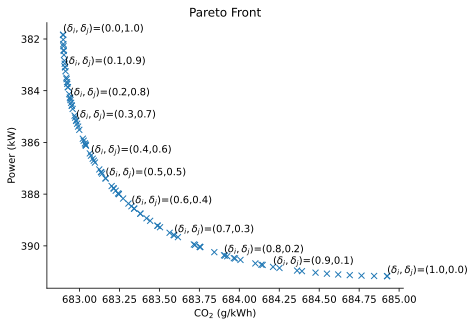

In [15]:
P_pareto_opt = POWfunc(x_pareto_opt)
C_pareto_opt = CO2func(x_pareto_opt)

plt.figure()
plt.plot(C_pareto_opt,P_pareto_opt,'x')
for i in range(101):
    if i%10 == 0:
        plt.annotate(f"($\delta_i,\delta_j$)=({round(delta_p_list[i],1)},{round(delta_c_list[i],1)})", (C_pareto_opt[i], P_pareto_opt[i]), ha='left',va = 'bottom')
plt.ylabel('Power (kW)')
plt.xlabel('CO$_2$ (g/kWh)')
plt.title('Pareto Front')
ax = plt.gca()
ax.invert_yaxis()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

:::{card} Test yourself
<iframe src="https://tudelft.h5p.com/content/1292260179152459667/embed" aria-label="Best model" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
<iframe src="https://tudelft.h5p.com/content/1292260184374358717/embed" aria-label="Timeing" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
:::

## Exercise

:::{card}
Click {fa}`rocket` --> {guilabel}`Live Code` and answer the following question:
<iframe src="https://tudelft.h5p.com/content/1292260188487459217/embed" aria-label="Not normalization" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
:::

## Questions, discussions and comments
<script src="https://utteranc.es/client.js"
        repo="TeachBooks/engineering-systems-optimization"
        issue-term="title"
        theme="github-light"
        crossorigin="anonymous"
        async>
</script>